In [7]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import scipy.sparse
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from ZIFA import ZIFA
from ZINB import ZINB
from SIMLR import SIMLR

from benchmarking import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
data_path = "data/10xPBMCs/"

# gene filtering once and for all from original matrix

In [9]:
gene_names = np.array(pd.read_csv(data_path + "michael_gene_names.csv", index_col=0)["x"], dtype=str)

In [10]:
expression = pd.DataFrame(scipy.io.mmread(data_path + "count.mtx").T.A, columns=gene_names)
expression.shape 

(12039, 22156)

#### select genes that are in the DE data

In [11]:
def dumb_prefix(x, n):
    if x != "GS":
        return str(n) + "_" + x
    else:
        return x

In [12]:
# load micro_array data and align existing genes
exp_data_1 = pd.read_csv(data_path+"gene_data/GSE8835_CD4_CD8.tab", delimiter="\t")
exp_data_1["GS"] = exp_data_1.index
exp_data_1.columns = [dumb_prefix(x, "CD") for x in exp_data_1.columns] 
exp_data_2 = pd.read_csv(data_path+"gene_data/GSE29618_Bcells_mDC.tab", delimiter="\t")
exp_data_2["GS"] = exp_data_2.index
exp_data_2.columns = [dumb_prefix(x, "BDC") for x in exp_data_2.columns]
exp_data_3 = pd.read_csv(data_path+"gene_data/GSE22886_Bcells_mDC.tab", delimiter="\t")
exp_data_3["GS"] = exp_data_3.index
exp_data_3.columns = [dumb_prefix(x, "BDC2") for x in exp_data_3.columns]
exp_data = pd.merge(exp_data_1, \
                          exp_data_2, how="inner", on="GS")
exp_data = pd.merge(exp_data, \
                          exp_data_3, how="inner", on="GS")
exp_data.shape

(6394, 19)

In [13]:
# order correspondance from datasets
gene_dataset_name = pd.DataFrame(gene_names, columns=["ENSG"])
gene_correspondance = pd.read_csv(data_path+"de/new_rownames.tab", delimiter="\t")
gene_correspondance.columns = ["ENSG", "GS"]
ordered_corres = pd.merge(gene_dataset_name, \
                          gene_correspondance, how="inner", on="ENSG", left_index=True)

In [14]:
micro_array_result = pd.merge(ordered_corres, exp_data, how="inner", on="GS", right_index=True)
micro_array_result.shape

(3346, 20)

In [15]:
micro_array_result.to_csv(data_path+"de/gene_info.csv")

In [16]:
expression = expression[micro_array_result["ENSG"]]

In [17]:
de_expression = np.copy(expression.as_matrix())
de_gene_names = expression.columns

In [12]:
selected = np.std(de_expression, axis=0).argsort()[-800:][::-1]
expression = expression[np.array(micro_array_result["ENSG"])[selected]]
gene_names = expression.columns.astype(str)

In [18]:
de_gene_names.shape

(3346,)

In [138]:
np.savetxt(data_path+"gene_data/gene_names.tab", gene_names, fmt='%s')

## now clusters and qc

In [19]:
design = pd.read_csv(data_path + "design.csv", index_col=0)
dim_names = ["WPC"+str(i) for i in range(1, 8)]
qc_pc = design[dim_names].as_matrix()
normalized_qc = pd.read_csv(data_path + "full_qc.csv", index_col=0)
barcodes = pd.read_csv(data_path + "barcodes.csv", index_col=1)
batch = pd.read_csv(data_path + "batch.csv", index_col=0)

In [20]:
raw_qc_8 = pd.read_csv(data_path + "molecule_qc_8k.txt", index_col=0, sep="\t")
raw_qc_8.index = raw_qc_8.index.map(lambda s: s+"-1")
raw_qc_4 = pd.read_csv(data_path + "molecule_qc_4k.txt", index_col=0, sep="\t")
raw_qc_8 = raw_qc_8.loc[barcodes.iloc[np.where(batch["x"] == "pbmc8k")[0], :].index.values]
number_suffix = barcodes.iloc[np.where(batch["x"] == "pbmc4k")[0], :].index.map(lambda s: str(s.split("-")[1])).values
barcode_prefix = barcodes.iloc[np.where(batch["x"] == "pbmc4k")[0], :].index.map(lambda s: str(s.split("-")[0])).values
raw_qc_4 = raw_qc_4.loc[barcode_prefix]
raw_qc_4.index = raw_qc_4.index +"-" +number_suffix

In [21]:
raw_qc = pd.concat((raw_qc_8, raw_qc_4)).loc[barcodes.index]

In [22]:
qc_pc.shape, normalized_qc.shape, raw_qc.shape, batch.shape

((12039, 7), (12039, 9), (12039, 9), (12039, 1))

In [23]:
bio = pd.read_csv(data_path + "bio.csv", index_col=0)
list_clusters = np.unique(bio["x"])
def string_to_cluster(string):
    return np.where(list_clusters == string)[0][0]
data_bio = bio["x"].apply(lambda i: string_to_cluster(i))
clusters = data_bio.values
counts = data_bio.value_counts()[range(0, 9)].values
print "dataset_population"
zip(list(np.unique(clusters)), list(list_clusters), list(counts))

dataset_population


[(0, 'B cells', 1625),
 (1, 'CD14+ Monocytes', 2237),
 (2, 'CD4 T cells', 5024),
 (3, 'CD8 T cells', 1452),
 (4, 'Dendritic Cells', 339),
 (5, 'FCGR3A+ Monocytes', 351),
 (6, 'Megakaryocytes', 88),
 (7, 'NK cells', 459),
 (8, 'Other', 464)]

In [24]:
_, batch = np.unique(batch, return_inverse=True)

In [25]:
X_train, X_test, \
de_X_train, de_X_test, \
c_train, c_test, \
r_train, r_test, \
b_train, b_test, \
qc_train, qc_test = \
                train_test_split(expression, de_expression, clusters, qc_pc, \
                                 batch, raw_qc.as_matrix(), random_state=0)

In [31]:
scipy.sparse.save_npz(data_path + "data_train.npz", scipy.sparse.coo_matrix(X_train))
scipy.sparse.save_npz(data_path + "data_test.npz", scipy.sparse.coo_matrix(X_test))

np.save(data_path + "de/data_train", de_X_train)
np.save(data_path + "de/data_test", de_X_test)

np.savetxt(data_path + "label_train", c_train)
np.savetxt(data_path + "label_test", c_test)

np.savetxt(data_path + "b_train", b_train)
np.savetxt(data_path + "b_test", b_test)

np.save(data_path + "design_train", r_train)
np.save(data_path + "design_test", r_test)

np.save(data_path + "qc_train", qc_train)
np.save(data_path + "qc_test", qc_test)

# Now benchmarking

In [26]:
n_latent = 10

In [4]:
#X_train = scipy.sparse.load_npz(data_path + "data_train.npz").A
#X_test = scipy.sparse.load_npz(data_path + "data_test.npz").A
X_train = np.load(data_path + "de/data_train.npy")
X_test = np.load(data_path + "de/data_test.npy")
r_train = np.load(data_path + "design_train.npy")
r_test = np.load(data_path + "design_test.npy")
c_train = np.loadtxt(data_path + "label_train")
c_test = np.loadtxt(data_path + "label_test")
b_train = np.loadtxt(data_path + "b_train")
b_test = np.loadtxt(data_path + "b_test")

In [34]:
algorithms = [PCA(n_components=n_latent, svd_solver="full"), \
              ZIFA(n_components=n_latent)]
alg_names = ["PPCA", "ZIFA"]
alg_logs = [True, True, False]

In [5]:
from sklearn.decomposition import FactorAnalysis
data_train = np.log(1 + X_train)
data_test = np.log(1 + X_test)
alg = FactorAnalysis(n_components=n_latent)        
%time alg.fit(data_train)
latent = alg.transform(data_train) 
score = alg.score(data_test)
score -= np.mean(np.sum(data_test, axis=-1))

CPU times: user 15.8 s, sys: 27.5 s, total: 43.3 s
Wall time: 6.57 s


In [60]:
score

359.96037027761338

In [99]:
np.mean(X_train == 0)

0.86342350943698254

(array([  9.02500000e+03,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

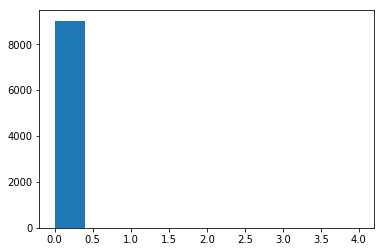

In [45]:
plt.hist(X_train[:, 1478])

In [74]:
#prepare the original values 
#all_index = i[ix], j[ix]
#y = X_train[all_index]
#y = y[X_zero[all_index] == 0]

y = X_train[:, 1478]
#y = X_train[:100, :].flatten()
ymax = 10
mask = y < ymax
y = y[mask]
l = y.shape[0]

x = np.zeros((l, 100))

# Now look at how the posterior covers the imputed values
for t in range(100):
    generate = alg.mean_ + np.dot(latent, alg.components_) + np.random.normal(0, scale = np.sqrt(alg.noise_variance_))
    generate = np.exp(generate) - 1
    #x_ = generate[all_index] 
    #x_ = x_[X_zero[all_index] == 0]
    x_ = generate[:, 1478]
    #x_ = generate[:100, :].flatten()
    x[:, t] = x_[mask]
    
mask = np.mean(x, axis=1) < ymax
x = x[mask]
y = y[mask]

l = np.minimum(x.shape[0], y.shape[0])

x = x[:l]
y = y[:l]

index = np.random.choice(l, size=100000)
x_ = x[index]
y_ = y[index]

data = [x_[y_ == t].flatten() for t in range(0, 9)]

In [83]:
alg.score(np.log(1 + X_train[7137:7138])) - np.sum(np.log(1 + X_train[7137:7138]))
plt.hist(1 / alg.noise_variance_)

-8329.3016258388125

In [94]:
data

[array([-0.0288428 , -0.00223381, -0.02836792, ..., -0.02759878,
        -0.01357825, -0.02311549]),
 array([ 0.0177997 ,  0.04440869,  0.01827458, ...,  0.02320514,
         0.03722567,  0.02768842]),
 array([ 0.87211448,  0.89872347,  0.87258936, ...,  0.87751992,
         0.89154045,  0.8820032 ]),
 array([], dtype=float64),
 array([ 0.70001733,  0.72662632,  0.70049221, ...,  0.70542277,
         0.7194433 ,  0.70990606]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

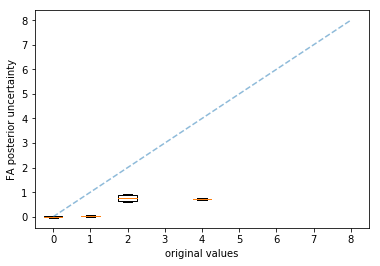

In [98]:
plt.figure()
plt.boxplot(data, sym="", positions=range(0, 9))

l = np.linspace(0, 8, 50)
plt.plot(l, l, linestyle="--", alpha=0.5)
plt.xlabel("original values")
plt.ylabel("FA posterior uncertainty")

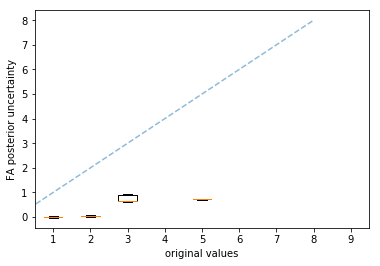

In [43]:
plt.figure()
plt.boxplot(data, sym="")

l = np.linspace(0, 8, 50)
plt.plot(l, l, linestyle="--", alpha=0.5)
plt.xlabel("original values")
plt.ylabel("FA posterior uncertainty")

In [55]:
from sklearn.utils.extmath import fast_logdet

In [67]:
Xr = np.log(1 + X_train) - alg.mean_
precision = alg.get_precision()
n_features = X_train.shape[1]
log_like = np.zeros(X_train.shape[0])
log_like = -.5 * (Xr * (np.dot(Xr, precision))).sum(axis=1)
log_like -= .5 * (n_features * np.log(2. * np.pi)
                  - fast_logdet(precision))

In [72]:
fast_logdet(precision)

11222.848027416316

In [73]:
(Xr * (np.dot(Xr, precision))).sum(axis=1).mean()

3345.9891200637467

In [68]:
np.mean(log_like)

863.66112157344992

In [69]:
log_like

array([ 1710.19842108,  1425.38352159,  1099.80890606, ...,  1443.91620878,
        1003.49319706,   701.55827701])

In [66]:
np.mean(np.sum(np.log(1 + X_test), axis=-1))

468.99929667535639

In [63]:
alg.score(X_test)

-97624.848905411665

In [22]:
np.exp(generate) - 1

array([[-0.24136458, -0.2204514 ,  0.03829172, ...,  0.03414789,
         0.43465342,  0.01290772],
       [-0.29143164, -0.20811361,  0.03487634, ...,  0.02574275,
         0.40457791,  0.00379334],
       [-0.19793623, -0.11862471,  0.05131207, ...,  0.04158357,
         0.46458267,  0.00808656],
       ..., 
       [-0.22502929, -0.1614503 ,  0.03991874, ...,  0.04218193,
         0.45265849,  0.01182606],
       [-0.19062229, -0.06642821,  0.04891827, ...,  0.04611559,
         0.47009259,  0.01227295],
       [-0.17964984, -0.09374464,  0.04833211, ...,  0.04715792,
         0.48772716,  0.01355886]])

In [8]:
alg.loglike_

[-28690640.835052349,
 7743101.0395801682,
 7795903.3560127942,
 7797770.9535132125,
 7797920.4244741052,
 7797922.949999609,
 7797957.7843294777,
 7797912.9699532362]

In [35]:
for i, alg in enumerate(algorithms):
    print i, alg_names[i]
    
    if i == 1:
        continue
    
    data_train = X_train
    data_test = X_test
    
    if alg_logs:
        data_train = np.log(1 + X_train)
        data_test = np.log(1 + X_test)
        
    %time alg.fit(data_train)
    latent = alg.transform(data_train)
    
    print cluster_scores(latent, 9, c_train)
    print entropy_batch_mixing(latent, b_train)
    
    score = alg.score(data_test)
    if alg_logs:
        score -= np.mean(np.sum(data_test, axis=-1))
        
    print score

0 PPCA
CPU times: user 2min 53s, sys: 29.5 s, total: 3min 22s
Wall time: 27.3 s
[0.32141702134965322, 0.68379185853166979, 0.54608277060671384]
0.622334973356
-411.635897778
1 ZIFA


In [9]:
# zinb = ZINB(n_components=n_latent, learn_V=True)
# % time zinb.fit(X_train)
# % time latent = zinb.transform(X_train)
# print zinb.score(X_test)
# print cluster_scores(latent, 9, c_train)

In [36]:
simlr = SIMLR(n_clusters=9)
%time simlr.fit_transform(X_train)
clear_output()
print cluster_scores(simlr.F, 9, c_train)
print entropy_batch_mixing(simlr.F, b_train)

[0.78212435541262204, 0.83751868977433352, 0.88378315126477902]
0.628411486367


## imputation

In [5]:
X_zero, i, j, ix = dropout(X_train, 1.25899381341, uniform=True)
np.save(data_path + "imputation/X_zero.npy", X_zero)
np.save(data_path + "imputation/i.npy", i)
np.save(data_path + "imputation/j.npy", j)
np.save(data_path + "imputation/ix.npy", ix)

In [24]:
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"),\
        np.load(data_path + "imputation/i.npy"), \
        np.load(data_path + "imputation/j.npy"), \
        np.load(data_path + "imputation/ix.npy")

In [ ]:
# ZIFA Imputation
zifa = ZIFA(n_components=10)
%time zifa.fit(np.log(1 + X_zero))
%time X_ZIFA_log = zifa.output_estimation(np.log(1 + X_zero))["EX"]
p_ZIFA = np.exp(- zifa.params["decay_coef"] * X_ZIFA_log**2)
print("ZIFA", imputation_error(np.exp(X_ZIFA_log) - 1, X_train, i, j, ix), \
              imputation_dropout(np.log(p_ZIFA), X_zero, i, j, ix))
del X_ZIFA_log
del p_ZIFA

In [ ]:
# ZINB Imputation
zinb = ZINB(n_components=10)
%time zinb.fit(X_zero)
%time zinb.score(X_zero)
fit_ZINB = zinb.output_estimation()
def softplus(x):
    return np.log(1 + np.exp(x))
X_ZINB = fit_ZINB[0]
logit_ZINB = fit_ZINB[1]
theta_ZINB = fit_ZINB[2]
log_pi_ZINB = -softplus(- logit_ZINB)
log_p_ZINB = softplus(- logit_ZINB + theta_ZINB * np.log(theta_ZINB + 1e-8) \
                      - theta_ZINB * np.log(theta_ZINB + X_ZINB + 1e-8)) -  softplus( - logit_ZINB)
print("ZINB", imputation_error(X_ZINB, X_train, i, j, ix),\
      imputation_dropout(log_pi_ZINB, X_zero, i, j, ix), imputation_dropout(log_p_ZINB, X_zero, i, j, ix))
del fit_ZINB

In [13]:
#MAGIC Imputation
mean_MAGIC = np.load(data_path + "imputation/X_zero_MAGIC.npy")
print("MAGIC", imputation_error(mean_MAGIC, X_train, X_zero, i, j, ix))

('MAGIC', 0.60782387893793932)


# Importing data

## Import of unnormalized data

In [41]:
raw_data = pd.read_csv(data_path + "raw.csv", index_col=0).T
gene_names = raw_data.columns
raw_counts = raw_data.as_matrix()

In [42]:
raw_projection = PCA(n_components=n_latent).fit_transform(np.log(1 + raw_counts))

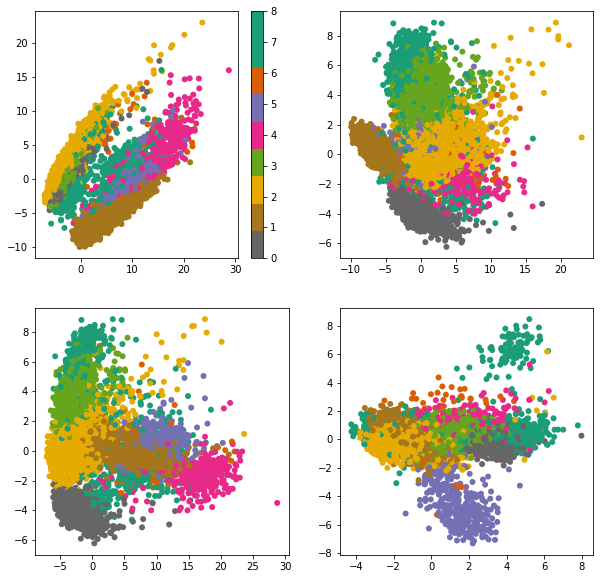

In [43]:
visualize(raw_projection, clusters)

In [44]:
print distances_metrics(raw_projection, clusters)
print best_clusters_score(raw_projection, 9, clusters)
print correlation_metrics(raw_projection, qc_matrix)

{'nne': 0.96835285322701226, 'silhouette': 0.31815870734273799}
{'ARI': 0.65642690008556781, 'F1': 0.48350443379882774, 'NMI': 0.70765635459610476}
0.366005028753


### PCs of residual wanted variation, normalized matrix

In [45]:
t = 8

In [46]:
for t in [1, 3, 8]:
    print t
    normalized_matrix = pd.read_csv(data_path + "qc_k_"+str(t)+"_projected.csv", index_col=0).T
    projection = PCA(n_components=n_latent).fit_transform(np.log(1 + normalized_matrix))
    print distances_metrics(projection, clusters)
    print best_clusters_score(projection, 9, clusters)
    print correlation_metrics(projection, qc_matrix)

1
{'nne': 0.95963119860453527, 'silhouette': 0.37140923010628191}
{'ARI': 0.6982585752051802, 'F1': 0.44850555330425307, 'NMI': 0.78178563372302046}
0.243980224047
3
{'nne': 0.94559348783121522, 'silhouette': 0.31136625725275013}
{'ARI': 0.63917116707621047, 'F1': 0.38657452958022248, 'NMI': 0.73333621827314233}
0.111946399922
8
{'nne': 0.93205415732203667, 'silhouette': 0.27042115448152881}
{'ARI': 0.6291411097994799, 'F1': 0.12295722451336803, 'NMI': 0.72008687323636589}
0.102620633576


# de benchmark

In [27]:
from IDR import IDR
from deseq import DESeq2
from mast import MAST
from deseq import edgeR

In [28]:
micro_array_result = pd.read_csv(data_path+"de/gene_info.csv")

In [29]:
micro_array_result.head()

,Unnamed: 0,ENSG,GS,CD_logFC,CD_AveExpr,CD_t,CD_P.Value,CD_adj.P.Val,CD_B,BDC_logFC,...,BDC_t,BDC_P.Value,BDC_adj.P.Val,BDC_B,BDC2_logFC,BDC2_AveExpr,BDC2_t,BDC2_P.Value,BDC2_adj.P.Val,BDC2_B
0,5,ENSG00000188976,NOC2L,0.248976,4.193230,1.308282,0.201059,0.478547,-5.465606,0.023141,...,0.199196,0.844018,0.936848,-6.964569,0.532702,5.985696,1.671825,0.116222,0.148453,-6.166109
1,7,ENSG00000187608,ISG15,-0.036463,5.769094,-0.216990,0.829737,0.919775,-6.272810,0.987879,...,3.449654,0.002391,0.019573,-2.095965,0.933572,6.303954,2.202136,0.044485,0.062851,-5.300666
2,36,ENSG00000149527,PLCH2,0.505600,3.225463,1.834575,0.076854,0.327638,-4.707168,-0.119499,...,-1.014781,0.321715,0.598441,-6.463128,-0.977612,4.232389,-3.119639,0.007349,0.012455,-3.569136
3,37,ENSG00000157881,PANK4,-0.093142,4.319701,-0.772409,0.446126,0.686981,-6.001137,0.024259,...,0.111785,0.912052,0.963969,-6.978668,0.183735,6.453772,1.306024,0.212100,0.252955,-6.668252
4,40,ENSG00000157873,TNFRSF14,0.073292,4.949553,0.353608,0.726192,0.865967,-6.233949,-0.377352,...,-2.465162,0.022361,0.106855,-4.215261,-0.075492,6.920026,-0.540324,0.597263,0.639609,-7.373536


In [30]:
def boostrap_scores_de(p_value, model, it, p_prior = 0.1, rank_auc=111):
    l = []
    for i in range(it):
        print i
        model_p_value = model.fit().astype(np.float64)
        res = idr.fit(-np.log(model_p_value), -np.log(p_value), p_prior=p_prior)
        auc = auc_score_threshold(p_value, model_p_value, rank_auc, p_value=True)
        res = list(res)
        res.append([auc])
        l.append([x[0] for x in res])    
    return l

In [31]:
gene_names = micro_array_result["ENSG"]
gene_symbols = micro_array_result["GS"]

In [32]:
# interest = "CD"
# couple_celltypes = (3, 2)
# rank_auc = 111
# p_prior = 0.03

interest = "BDC"
couple_celltypes = (0, 4)
rank_auc = 800
p_prior = 0.25

# getting p_values
p_value = micro_array_result[interest + "_adj.P.Val"].values
signed_p_value = - np.log10(p_value) * np.sign(micro_array_result[interest + "_logFC"].values)

In [33]:
idr = IDR()
deseq_2 = DESeq2(100, 100, \
                 data_path + "de/data_train.npy",\
                 data_path + "label_train", \
                    couple_celltypes)
mast = MAST(100, 100, \
                 data_path + "de/data_train.npy",\
                 data_path + "label_train", \
                    couple_celltypes)

edger = edgeR(100, 100, data_path + "de/data_train.npy",\
                 data_path + "label_train", \
                    couple_celltypes) 

In [34]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


BDC_Detected  1894  genes with MAST
BDC_Detected  879  genes with microarray


/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sign
  if __name__ == '__main__':
/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


BDC_Detected  360  genes with DESeq
BDC_Detected  879  genes with microarray


/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less_equal


BDC_Detected  1219  genes with edgeR
BDC_Detected  879  genes with microarray


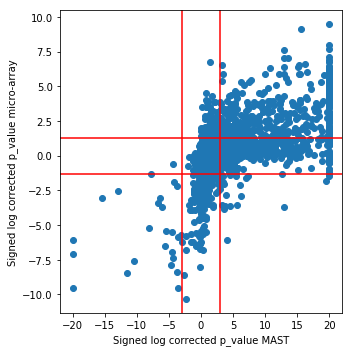

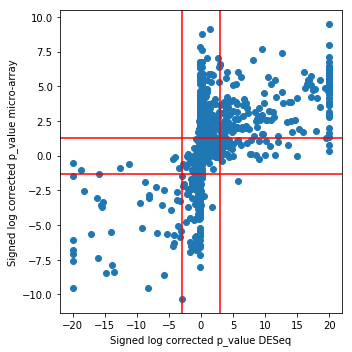

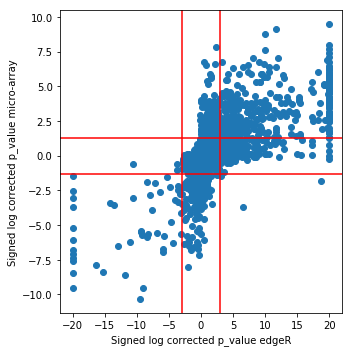

In [36]:
alg_list = ["MAST", "DESeq", "edgeR"]
estim_list = [mast, deseq_2, edger]
for t in range(3):
    alg = alg_list[t]
    estim = estim_list[t]
    p, fc = estim.fit(return_fc=True)

    p = np.array(stats.p_adjust(FloatVector(p), method = 'BH'))
    signed_p = - np.log10(p) * np.sign(fc)

    signed_p[signed_p >= 20] = 20
    signed_p[signed_p <= -20] = -20

    plt.figure(figsize=(5, 5))
    plt.scatter(signed_p, signed_p_value)
    plt.axvline(x=3, c="r")
    plt.axvline(x=-3, c="r")
    plt.axhline(y=np.log10(0.05), c="r")
    plt.axhline(y=-np.log10(0.05), c="r")
    plt.xlabel("Signed log corrected p_value "+alg)
    plt.ylabel("Signed log corrected p_value micro-array")
    plt.tight_layout()
    plt.savefig(interest + "_"+ alg + "_vs_micro_array.pdf", dpi=300)
    print interest + "_" + "Detected ", np.sum(p <= 0.05), " genes with " + alg
    print interest + "_" + "Detected ", np.sum(p_value <= 0.05), " genes with microarray"

In [39]:
boostrap_scores_de(p_value, edger, 20, p_prior=p_prior, rank_auc=rank_auc)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[[0.073530264912539028, 0.76195418663262859, 0.77699152011362205],
 [0.068250986446227457, 0.76407072488814065, 0.75826893353941272],
 [0.077765533677118415, 0.77260147889449005, 0.7276271634849687],
 [0.06571610300534475, 0.74687195787500604, 0.72894300792291511],
 [0.066476238389557463, 0.81145682788121143, 0.72523775707701532],
 [0.073137387809561, 0.73231267047962778, 0.75063842822729998],
 [0.067199978491508036, 0.82443267559563582, 0.7312196276647589],
 [0.076060841551785857, 0.73331833113736489, 0.74386148126488161],
 [0.066649895844789767, 0.7419593462360633, 0.75332442179428261],
 [0.070325053965708775, 0.75922082702337057, 0.70693150646782799],
 [0.070269363881499861, 0.77580140511537032, 0.75295125109653716],
 [0.066838485681943213, 0.78232651181128521, 0.73260509350153857],
 [0.072138465222251119, 0.75967116402180879, 0.72413077683556826],
 [0.070912261946707938, 0.77283260186826508, 0.7374312488686523],
 [0.077054115195049844, 0.76841790311523128, 0.76475486305470852],
 [0

##### deseq

In [40]:
boostrap_scores_de(p_value, deseq_2, 20, p_prior=p_prior, rank_auc=rank_auc)

0


/home/romain/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[[0.032902867101084761, 0.75064093569227797, 0.52526938374252241],
 [0.036789116382926083, 0.72017810096583035, 0.5179735461816265],
 [0.056749138334733717, 0.56656014843078162, 0.52498740987703107],
 [0.053730686712023967, 0.53090684455984949, 0.5306070519810977],
 [0.039129326918783583, 0.67061776463314104, 0.56007875281260056],
 [0.034052745141134398, 0.69409934011357677, 0.52993442061155505],
 [0.053500138973116597, 0.60034740095641459, 0.52857115763920492],
 [0.036578018526089592, 0.71090287459174029, 0.52722321624760649],
 [0.033767152313007941, 0.70978620792624969, 0.51776167095316028],
 [0.037461152311075947, 0.70510829261397867, 0.52464612260895827],
 [0.032786172923720942, 0.71062023825762077, 0.53715575721464059],
 [0.036776903122752322, 0.69476703943609541, 0.50803282689608897],
 [0.031149835542971429, 0.73337895785256335, 0.51878387978316931],
 [0.031469050849262284, 0.76241826912790078, 0.52070611885915308],
 [0.032477264713363083, 0.76937458923521596, 0.53382288143281109

##### MAST

In [41]:
boostrap_scores_de(p_value, mast, 20, p_prior=p_prior, rank_auc=rank_auc)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


[[0.065781157888356173, 0.76990326605871884, 0.7609410028266288],
 [0.062784048122332473, 0.80917994940195381, 0.71204310957015748],
 [0.063971421212487903, 0.77001789394647091, 0.72957517022432006],
 [0.060448377538310706, 0.8125881475527672, 0.72636840859406548],
 [0.066768861752931272, 0.7854925099161234, 0.70587186877758745],
 [0.063340469095832436, 0.81813090452909309, 0.72191960120862753],
 [0.061036225462394837, 0.82093187501924691, 0.75659941239539386],
 [0.070572252155508608, 0.77022310055222787, 0.74184663798265049],
 [0.063235704755484873, 0.81860553895462995, 0.72209226227773371],
 [0.066928372070680031, 0.82596621361863576, 0.72422685436595791],
 [0.07967038190921473, 0.79923288463129472, 0.7388919058161717],
 [0.063989746041377762, 0.78559024397455945, 0.72696993747998384],
 [0.067434143767636387, 0.75430709654858719, 0.74708773688680941],
 [0.059395332998462259, 0.71476823798946998, 0.74906916189760087],
 [0.063526875290721915, 0.79988289017266589, 0.75284681899828731],
